# [모의 경진대회] 교통물류 통행량 시계열 예측 모델


## 데이터 디렉토리 구조
아래 셀은 실행하지 마세요:

DATA/  
  \_train.csv  
  \_validate.csv  
  \_test.csv  
  \_sample_submission.csv

## 필수 라이브러리 불러오기

In [1]:
# 라이브러리 임포트
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data
from torch.optim import Adam, SGD
import datetime as dt
from datetime import timedelta

import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import time
import warnings

![](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

EDA(Graph)정리 링크 : https://evening-satin-e96.notion.site/Traffic-EDA-graph-4bafbae26b924d999b8b03f9a055949f

## 데이터 전처리

#### 데이터 경로

In [28]:
#모든 데이터가 들어있는 폴더 경로 
DATASET_PATH = os.path.join('/USER/2nd_competition/Traffic/DATA')

#### 시간정보를 Index로 변환

In [5]:
# 경고 무시 
plt.style.use('fivethirtyeight')
pd.set_option('mode.chained_assignment',  None)

# 데이터 불러오기
train = pd.read_csv(os.path.join(DATASET_PATH, 'train.csv'))
val = pd.read_csv(os.path.join(DATASET_PATH, 'validate.csv'))
test = pd.read_csv(os.path.join(DATASET_PATH, 'test.csv'))

# 날짜와 시간이 들어있는 columns를 index로 변환하는 함수
def datesetting(train): 
    train['날짜1'] = train['날짜'].astype(str)
    train['시간1'] = train['시간'].astype(str)
    train['date'] = train['날짜1']+train['시간1']

    for i in range (0,len(train['날짜'])):
        a = train['날짜1'][i]
        train['날짜1'][i] = dt.datetime.strptime(a, '%Y%m%d')

    for i in range(0,len(train['시간'])):
        b = train['시간1'][i]
        train['시간1'][i] = dt.datetime.strptime(b, '%H')

    for i in range(0,len(train['날짜'])):
        train['date'][i] = train['날짜1'][i]+timedelta(hours=train['시간1'][i].hour)

# 날짜와 시간이 들어있는 columns를 index로 변환
datesetting(train)
datesetting(val)
datesetting(test)

# 기존의 날짜, 시간 columns 제거
train=train.drop(['날짜1','시간1','날짜','시간'],axis=1)
val=val.drop(['날짜1','시간1','날짜','시간'],axis=1)
test=test.drop(['날짜1','시간1','날짜','시간'],axis=1)

# 인덱스 재지정
train_df=train.set_index('date')
val_df=val.set_index('date')
test_df=test.set_index('date')

# values를 Float형으로 변환
train_df = train_df.astype(float)
val_df = val_df.astype(float)

#### 데이터 shape 확인

In [6]:
print(train_df.shape) #train_df의 shape을 확인
print(val_df.shape) #val_df의 shape을 확인
print(test_df.shape) #test_df의 shape을 확인

(3279, 35)
(336, 35)
(336, 35)


# 하이퍼파라미터 및 기타 인자 설정

#### 시드 설정

In [7]:
# 난수 생성기가 항상 일정한 값을 출력하게 하기 위해 seed 고정
random_seed = 2022
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

#### 디바이스 설정

In [8]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### 하이퍼파라미터 설정

In [9]:
EPOCHS = 20
HIDDEN_DIM = 64
LEARNING_RATE = 1e-4
NUM_WORKERS = 4
BATCH_SIZE = 1                                   # Dataset 길이에 맞추어 1로 설정                           
FEATURE_DIM = 35                                   #feature dim -> 35개 도로입니다.
BACKCAST_LENGTH = 168
FORECAST_LENGTH = 168

#### 기타 인자 설정

In [10]:
PIN_MEMORY = True     # True로 한 뒤에 작동이 느리거나 이상이 있다면 False, default 값은 False

## Dataset 정의

#### Scaler 클래스 정의

In [11]:
# 데이터를 normailze하는 클래스
class StandardScaler():   
    def __init__(self):
        self.mean = None
        self.stdev = None
        
    def fit(self, x, dim=None):
        if not torch.is_tensor(x):  # numpy array -> torch tensor 
            x = torch.tensor(x)

        
        if dim is not None:
            self.mean = x.mean(dim)
            self.stdev = x.std(dim)
        else:
            self.mean = x.mean()
            self.stdev = x.std()
        
    def scale(self, x):

        if not torch.is_tensor(x): # numpy array -> torch tensor 
            x = torch.tensor(x)
        return (x - self.mean.to(x.device)) / self.stdev.to(x.device)
    
    def unscale(self, x):
        if not torch.is_tensor(x): # numpy array -> torch tensor 
            x = torch.tensor(x)
        return x * self.stdev.to(x.device) + self.mean.to(x.device)

#### Custom Dataset 정의

In [12]:
class TimeseriesDataset(torch.utils.data.Dataset):                             
    def __init__(self, data, backcast_length, forecast_length, scaler=None): 
        self.data_columns = data.columns                                       #columns 지정
        self.data = data.values                                                #values 지정
        self.backcast_length = backcast_length                                 #input data 길이 지정
        self.forecast_length = forecast_length                                 #output data 길이 지정
        
        if scaler is None:
            # train
            self.scaler = StandardScaler()
            self.scaler.fit(self.data, dim=0)
        else:
            self.scaler = scaler
        self.data = self.scaler.scale(self.data)
        

    def __len__(self): 
        return len(self.data) - self.backcast_length - self.forecast_length + 1

    def __getitem__(self, idx): 
        x_end = idx + self.backcast_length
        y_end = x_end + self.forecast_length

        x = self.data[idx:x_end]
        y = self.data[x_end:y_end]
        
        x = x.float()
        y = y.float()
        
        return x, y 
    
    def unscale(self, x):
        return self.scaler.unscale(x)

# 모델 정의

In [13]:
class RNNmodel(nn.Module):
    def __init__(self, feature_dim, hidden_dim, LSTM=False, GRU=True, num_layers=4, 
                 bidirectional=False, dropout=0.3, batch_first=True, 
                 backcast_length=168, forecast_length=168):
        super(RNNmodel, self).__init__()
        self.LSTM = LSTM # LSTM인지 아닌지 여부를 저장
        self.n_direction = 2 if bidirectional else 1
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        
        if LSTM:
            rnn = nn.LSTM
        elif GRU:
            rnn = nn.GRU
        else:
            rnn = nn.RNN
            
            
        self.rnn = rnn(input_size = feature_dim, 
                       hidden_size = hidden_dim, 
                       num_layers = num_layers,
                       bias = True,
                       batch_first = batch_first,
                       dropout = dropout,
                       bidirectional = bidirectional)

        self.out = nn.Linear(hidden_dim * self.n_direction, feature_dim)
        
    def forward(self, x):
        if self.LSTM:
            h0 = (torch.zeros(self.num_layers * self.n_direction, x.shape[0], self.hidden_dim, device=x.device),
                  torch.zeros(self.num_layers * self.n_direction, x.shape[0], self.hidden_dim, device=x.device))
        else:
            h0 = torch.zeros(self.num_layers * self.n_direction, x.shape[0], self.hidden_dim, device=x.device)
        
        x, h = self.rnn(x, h0)
        outs = []
        for i in range(self.forecast_length):
            x = self.out(x[:,-1:,:])
            outs.append(x.squeeze(0))
            
            if i == self.forecast_length-1:
                break
                
            x, h = self.rnn(x, h)
            
        outs = torch.stack(outs, dim=1)
        return outs

# 모델 학습

#### Dataset & Dataloader 설정

In [14]:
train_dataset = TimeseriesDataset(train_df, BACKCAST_LENGTH, FORECAST_LENGTH, scaler=None)
val_dataset = TimeseriesDataset(val_df, BACKCAST_LENGTH, FORECAST_LENGTH, scaler=train_dataset.scaler)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                                               num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                                               num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)


#### 모델과 기타 인자 설정

In [15]:
model = RNNmodel(FEATURE_DIM, HIDDEN_DIM, LSTM=False, GRU=True).to(DEVICE) #성능고도화를 위해 GRU = True로 설정해서 진행
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

#### Epoch 단위 학습 진행

In [16]:
warnings.filterwarnings("ignore")

train_losses = []
val_losses = []

best_epoch = 0
best_model_state_dict = None
best_val_loss = 10000

start_time = time.time()

for epoch in range(EPOCHS):
    train_loss_mean = 0
    val_loss_mean = 0
    
    # train
    model.train()
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        forecast = model(inputs)
        loss = criterion(forecast.sum(0), labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_mean += loss.item()
        
        if i % 100 == 0:
            print('epoch [{}/{}] iter [{:03d}/{:03d}] loss [{:.4f}] elapsed time [{:.2f}min]'.format(epoch, EPOCHS, i, len(train_dataloader), loss.item(), (time.time()-start_time)/60))
    
    train_loss_mean = train_loss_mean/len(train_dataloader)
    
    train_losses.append(train_loss_mean)
    
    # validation
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            forecast = model(inputs)
            loss = criterion(forecast.sum(0), labels)
            val_loss_mean += loss.item()

        val_loss_mean = val_loss_mean/len(val_dataloader)

        print('epoch [{}/{}] train loss [{:.4f}] validation loss [{:.4f}] elapsed time [{:.2f} min]\n'.format(epoch, EPOCHS, train_loss_mean, val_loss_mean, (time.time()-start_time)/60))

        if val_loss_mean < best_val_loss:
            best_epoch = epoch
            best_val_loss = val_loss_mean
            torch.save(model.state_dict(), "best-model.pt")
    val_losses.append(val_loss_mean)


epoch [0/20] iter [000/2944] loss [1.0530] elapsed time [0.01min]
epoch [0/20] iter [100/2944] loss [0.8678] elapsed time [0.42min]
epoch [0/20] iter [200/2944] loss [0.6712] elapsed time [0.81min]
epoch [0/20] iter [300/2944] loss [0.4550] elapsed time [1.22min]
epoch [0/20] iter [400/2944] loss [0.2842] elapsed time [1.62min]
epoch [0/20] iter [500/2944] loss [1.1019] elapsed time [2.04min]
epoch [0/20] iter [600/2944] loss [0.1860] elapsed time [2.44min]
epoch [0/20] iter [700/2944] loss [0.1632] elapsed time [2.85min]
epoch [0/20] iter [800/2944] loss [0.4152] elapsed time [3.27min]
epoch [0/20] iter [900/2944] loss [0.1604] elapsed time [3.68min]
epoch [0/20] iter [1000/2944] loss [0.9735] elapsed time [4.09min]
epoch [0/20] iter [1100/2944] loss [0.2063] elapsed time [4.51min]
epoch [0/20] iter [1200/2944] loss [0.2767] elapsed time [4.92min]
epoch [0/20] iter [1300/2944] loss [0.2834] elapsed time [5.33min]
epoch [0/20] iter [1400/2944] loss [0.2206] elapsed time [5.72min]
epoch

#### Validation loss 확인

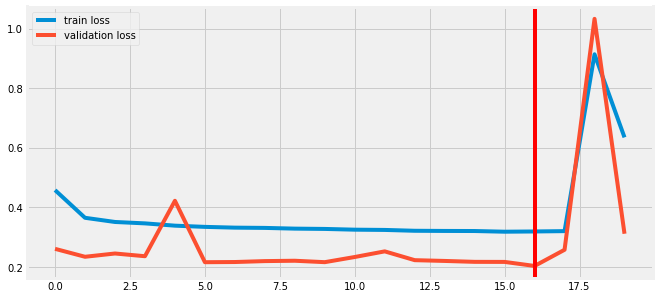

In [17]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.axvline(best_epoch, color='red')
plt.legend()
plt.show()

# 추론

#### 테스트 Dataset, DataLoader 설정

In [18]:
test_dataset = TimeseriesDataset(test_df, BACKCAST_LENGTH, FORECAST_LENGTH, scaler=train_dataset.scaler)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                                               num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

#### 최고 성능 모델 불러오기

In [19]:
model.load_state_dict(torch.load('best-model.pt'))

<All keys matched successfully>

#### 추론 진행

In [20]:
predictions = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(DEVICE)
        forecast = model(inputs)
        predictions.append(forecast.data.cpu())

In [27]:
train_dataset.scaler.unscale(predictions)[0].shape

torch.Size([168, 35])

In [29]:
train_dataset.scaler.unscale(predictions)[0].shape

torch.Size([168, 35])

#### 예측 결과 파일 만들기

In [33]:
# predictions = torch.cat(predictions, dim=0)
submission_file_path = os.path.join(DATASET_PATH, 'sample_submission.csv')
submission_table = pd.read_csv(submission_file_path)
submission_table.iloc[:,1:]= train_dataset.scaler.unscale(predictions)[0]
submission_table

,timestamp,10,100,101,120,121,140,150,160,200,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200525_0,67566.807681,11460.134929,983.650270,2769.467384,912.187063,703.466816,25051.738730,767.324189,1891.354923,...,478.763843,2383.593180,5410.813118,4098.738700,1191.321644,3370.409520,267.786028,1479.324829,1336.970471,1889.604904
1,20200525_1,55048.754359,9252.971021,762.899229,2086.298798,710.089688,556.844239,20464.153371,631.502118,1584.469499,...,353.161724,2074.249319,4063.783008,3413.819670,969.187485,2900.235893,237.712564,1239.254616,1097.984215,1575.578501
2,20200525_2,49353.142323,8431.548222,662.385937,1673.380586,583.498046,478.592386,18037.560720,576.819139,1487.624684,...,281.288069,1937.219272,3396.567303,3083.361653,822.255289,2623.984029,238.233660,1212.557481,990.063390,1429.250499
3,20200525_3,49037.175865,8657.223919,646.201069,1432.574901,480.654454,433.920537,16420.419829,573.541442,1453.838560,...,205.287210,1861.499879,3121.522660,2878.243453,716.963879,2309.397095,246.475241,1279.705455,953.161538,1415.914875
4,20200525_4,60068.606203,11511.549870,428.654854,1955.002517,440.722326,629.164214,19976.879923,552.172245,1372.865066,...,357.633477,2264.402034,5311.748371,3042.146560,823.289726,2318.923533,280.901976,1578.093550,1181.196390,2459.799594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,20200531_19,277020.556648,71984.930661,7176.315921,17958.535225,7365.684664,5206.093376,113060.422974,4946.118562,12179.675761,...,5632.111612,13052.873768,33256.701991,18058.628689,5482.338019,16973.545140,2855.807821,13466.158350,8605.197958,15150.040284
164,20200531_20,244865.671109,55236.419541,5110.074396,12927.587142,5042.084436,3691.539605,96790.936363,3687.446803,9035.983942,...,3881.099056,10506.889078,28213.065690,15709.712814,4451.614922,13205.617957,1917.205749,9414.607451,6428.157459,10995.838902
165,20200531_21,208339.705391,42387.122527,3638.479275,9018.944351,3353.981591,2571.775021,79698.347180,2712.214079,6578.501232,...,2650.130905,7756.237717,22599.452866,12739.017214,3438.028237,10220.189805,1314.046429,6650.817474,4821.256399,7842.087456
166,20200531_22,161379.087000,30377.541644,2567.075869,6456.797282,2181.482586,1759.418759,59538.483772,1957.248979,4631.926479,...,1708.101388,5273.201435,15775.263871,9468.200727,2457.632547,7479.922532,861.730292,4503.500760,3402.110653,5208.806618


#### 결과 저장

In [34]:
submission_table.to_csv('prediction_20.csv', index=False)